### Imports

In [201]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import classification_report
import os
import cv2
import random
import math
from matplotlib import gridspec
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torchvision import models, transforms
from PIL import Image

### Load saved data

In [207]:
X_test = np.load("test_features.npy")
y_test = np.load("test_labels.npy")
svm = joblib.load("svm_sign_language_model.pkl")
le = joblib.load("label_encoder.pkl")

# Predict
y_pred = svm.predict(X_test)

### Global metrics

In [ ]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (macro)", "Recall (macro)", "F1 Score (macro)"],
    "Score": [f"{acc:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"]
})

print("Test Set Metrics:")
print(tabulate(metrics_table, headers="keys", tablefmt="pretty", showindex=False))

Test Set Metrics:
+-------------------+--------+
|      Metric       | Score  |
+-------------------+--------+
|     Accuracy      | 0.9042 |
| Precision (macro) | 0.9297 |
|  Recall (macro)   | 0.9042 |
| F1 Score (macro)  | 0.8989 |
+-------------------+--------+


### Mistakes: True vs Predicted

In [ ]:
comparison_df = pd.DataFrame({
    "True_Label": le.inverse_transform(y_test),
    "Predicted_Label": le.inverse_transform(y_pred)
})

mistakes = comparison_df[comparison_df["True_Label"] != comparison_df["Predicted_Label"]]

print(f"\nTotal mistakes: {len(mistakes)} out of {len(y_test)} test samples.")
print("Mistakes (True vs Predicted):")
print(tabulate(mistakes, headers="keys", tablefmt="pretty", showindex=False))


Total mistakes: 138 out of 1440 test samples.
Mistakes (True vs Predicted):
+-----------------------------------+----------------------------------------+
|            True_Label             |            Predicted_Label             |
+-----------------------------------+----------------------------------------+
|        1. gradsforbrenning        |          2. gradsforbrenning           |
|       3. gradsforbrenning 1       |          2. gradsforbrenning           |
|       3. gradsforbrenning 2       |          2. gradsforbrenning           |
|       3. gradsforbrenning 2       |          2. gradsforbrenning           |
|     EKG (elektrokardiografi)      |               beinbrudd                |
|    ME (myalgisk encefalopati)     |               kolesterol               |
|              alkohol              |                gebiss 1                |
|            ambulanse 2            |              drypp (TIA)               |
|              anfall               |               be

### Most Common Mistakes

In [15]:
# Create a list of all mistakes
confused_pairs = []
for true, pred in zip(y_test, y_pred):
    if true != pred:
        confused_pairs.append((le.inverse_transform([true])[0],
                               le.inverse_transform([pred])[0]))

# Count most common mistakes
counter = Counter(confused_pairs)

most_common_mistakes = pd.DataFrame(counter.most_common(10), columns=['(True_Label, Predicted_Label)', 'Count'])
most_common_mistakes[['True_Label', 'Predicted_Label']] = pd.DataFrame(most_common_mistakes['(True_Label, Predicted_Label)'].tolist(), index=most_common_mistakes.index)

# Drop the old combined column
most_common_mistakes = most_common_mistakes.drop(columns=['(True_Label, Predicted_Label)'])
most_common_mistakes = most_common_mistakes[['True_Label', 'Predicted_Label', 'Count']]

print("\nMost Common Mistakes:")
print(tabulate(most_common_mistakes, headers="keys", tablefmt="pretty", showindex=False))



Most Common Mistakes:
+----------------------------+---------------------+-------+
|         True_Label         |   Predicted_Label   | Count |
+----------------------------+---------------------+-------+
|   3. gradsforbrenning 2    | 2. gradsforbrenning |   2   |
|         frysninger         |       gåsehud       |   2   |
|          gåsehud           |     frysninger      |   2   |
|           kirurg           |       kirurgi       |   2   |
|          pasient           |     psykiater 1     |   2   |
|        seksualitet         |       samleie       |   2   |
|    1. gradsforbrenning     | 2. gradsforbrenning |   1   |
|   3. gradsforbrenning 1    | 2. gradsforbrenning |   1   |
|  EKG (elektrokardiografi)  |      beinbrudd      |   1   |
| ME (myalgisk encefalopati) |     kolesterol      |   1   |
+----------------------------+---------------------+-------+


### Video/class the model predicted best

In [ ]:
# Get all correctly predicted classes
correct_preds = [true for true, pred in zip(y_test, y_pred) if true == pred]

# Count frequency of correct predictions per class
correct_counts = Counter(correct_preds)

# Get top 10 most correctly predicted classes
top_10_correct = correct_counts.most_common(15)

# Decode to class names
top_10_df = pd.DataFrame(top_10_correct, columns=['Class_ID', 'Correct_Predictions'])
top_10_df['Class_Label'] = le.inverse_transform(top_10_df['Class_ID'])

# Reorder columns
top_10_df = top_10_df[['Class_Label', 'Correct_Predictions']]

print("\nTop 15 Most Accurately Recognized Classes:")
print(tabulate(top_10_df, headers="keys", tablefmt="pretty", showindex=False))


Top 15 Most Accurately Recognized Classes:
+----------------------------+---------------------+
|        Class_Label         | Correct_Predictions |
+----------------------------+---------------------+
|   3. gradsforbrenning 2    |          2          |
|          E. coli           |          2          |
| EEG (elektroencefalografi) |          2          |
|  EKG (elektrokardiografi)  |          2          |
| ME (myalgisk encefalopati) |          2          |
|  MS (multippel sklerose)   |          2          |
|           abort            |          2          |
|         abstinens          |          2          |
|       adferd_atferd        |          2          |
|        aggresjon 1         |          2          |
|        aggresjon 2         |          2          |
|         akupunktur         |          2          |
|          akutt 1           |          2          |
|          akutt 2           |          2          |
|          alkohol           |          2          |
+-

### Signs with lowest recall

In [ ]:
# Generate classification report as dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Turn into DataFrame
class_report = pd.DataFrame(report_dict).T

# Remove the global rows
class_report = class_report.iloc[:-3]

# Add the true labels
class_report["label"] = le.classes_

# Sort by Recall
lowest_recall = class_report.sort_values(by="recall", ascending=True)
lowest_recall = lowest_recall[["label", "precision", "recall", "f1-score"]]

print("Signs with Lowest Recall:")
print(tabulate(lowest_recall.head(10), headers="keys", tablefmt="pretty", showindex=False))

Signs with Lowest Recall:
+-----------------------+-----------+--------+--------------------+
|         label         | precision | recall |      f1-score      |
+-----------------------+-----------+--------+--------------------+
|        pasient        |    0.0    |  0.0   |        0.0         |
|       sykehjem        |    0.0    |  0.0   |        0.0         |
|      seksualitet      |    0.0    |  0.0   |        0.0         |
|        gåsehud        |    0.0    |  0.0   |        0.0         |
|      frysninger       |    0.0    |  0.0   |        0.0         |
|     moden_modent      |    0.0    |  0.0   |        0.0         |
| 3. gradsforbrenning 2 |    0.0    |  0.0   |        0.0         |
|   førstehjelpskurs    |    0.0    |  0.0   |        0.0         |
|        kirurg         |    0.0    |  0.0   |        0.0         |
|        hudvev         |    1.0    |  0.5   | 0.6666666666666666 |
+-----------------------+-----------+--------+--------------------+


### Video examples (in frames)

Selected video: C:\Users\erlen\OneDrive\Emma\CNN_LSTM_SIGN_LANGUAGE_PROJECT\Last_test\ResizedVideos_224\bleie\bleie.mp4


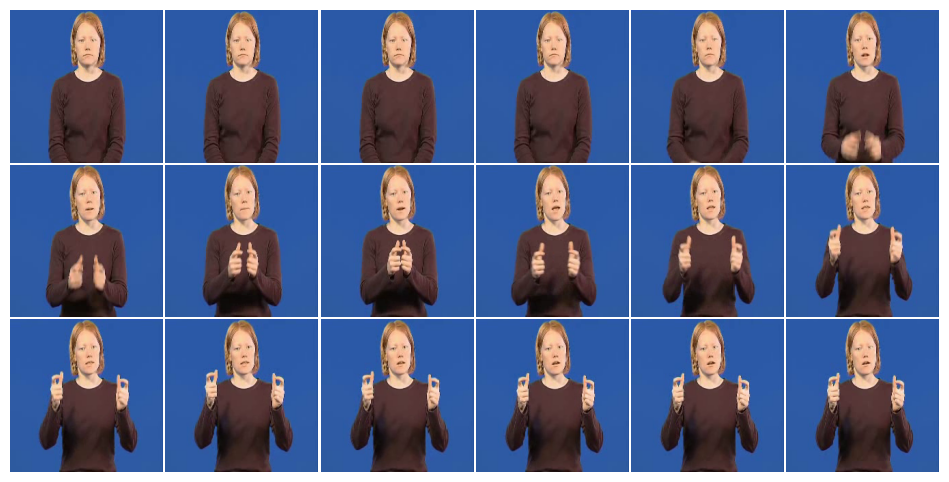

In [ ]:
video_folder = "ResizedVideos_224"

# Pick a random video
all_videos = []
for term_name in os.listdir(video_folder):
    term_path = os.path.join(video_folder, term_name)
    if not os.path.isdir(term_path):
        continue
    for file in os.listdir(term_path):
        if file.endswith('.mp4'):
            all_videos.append(os.path.join(term_path, file))

video_path = random.choice(all_videos)
print(f"Selected video: {video_path}")

# Load the video
cap = cv2.VideoCapture(video_path)
frames = []
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_idx % 2 == 0: 
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    frame_idx += 1

cap.release()

# Plot 
n_frames_to_plot = min(18, len(frames))
selected_frames = np.linspace(0, len(frames) - 1, n_frames_to_plot, dtype=int)

cols = 6
rows = int(np.ceil(n_frames_to_plot / cols))

fig = plt.figure(figsize=(cols * 2, rows * 2))
gs = gridspec.GridSpec(rows, cols, wspace=0.01, hspace=0.01)

for i, frame_idx in enumerate(selected_frames):
    ax = fig.add_subplot(gs[i])
    ax.imshow(frames[frame_idx])
    ax.axis("off")

plt.show()


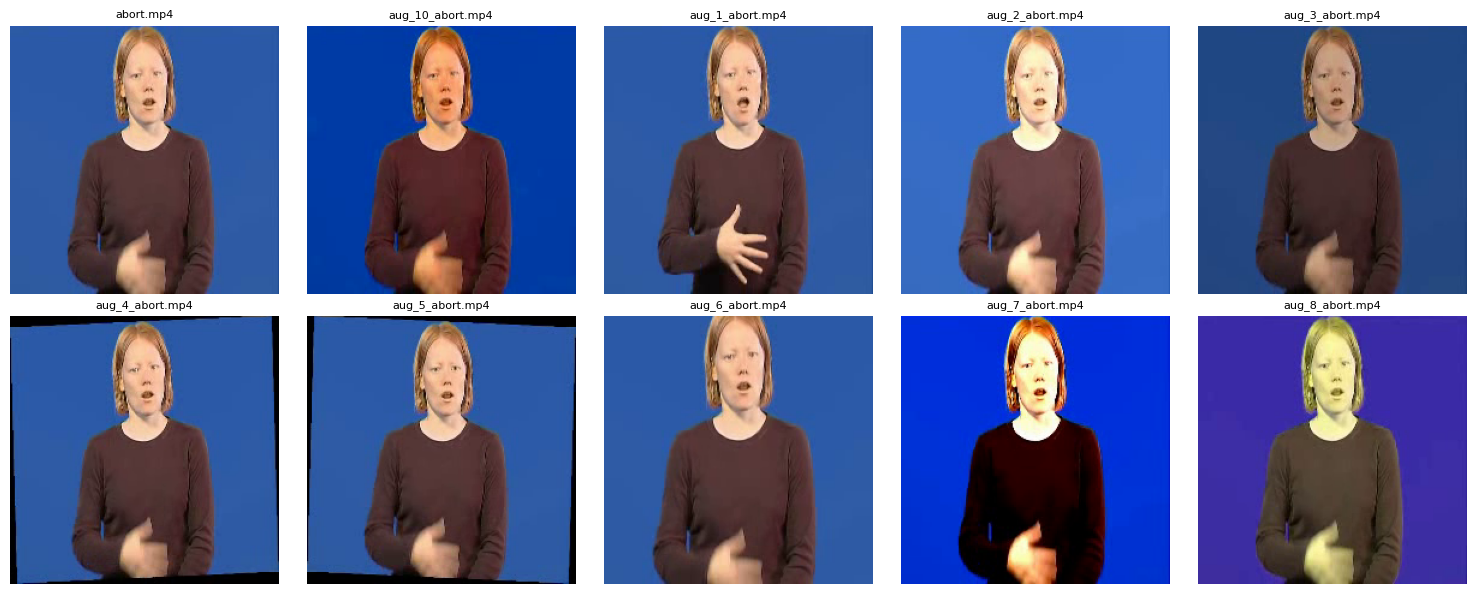

In [ ]:
def plot_augmented_frames(term_folder, frame_index=10):
    video_files = sorted(
        [f for f in os.listdir(term_folder) if f.endswith('.mp4') and not f.startswith("original")]
    )

    if len(video_files) < 10:
        print("Warning: Less than 10 augmented videos found.")
        return

    frames = []
    video_names = []

    for video_file in video_files[:10]:
        video_path = os.path.join(term_folder, video_file)
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            video_names.append(video_file)
        cap.release()

    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for ax, frame, name in zip(axes.flatten(), frames, video_names):
        ax.imshow(frame)
        ax.set_title(name, fontsize=8)
        ax.axis('off')

    # Hide any unused subplots
    for ax in axes.flatten()[len(frames):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

term_folder = "ResizedVideos_224\abort"
plot_augmented_frames(term_folder, frame_index=10)


### Testing with new videos

In [ ]:
# Paths
video_folder = "nsl_test"
svm_path = "svm_sign_language_model.pkl"
le_path = "label_encoder.pkl"

# Load model + label encoder
svm = joblib.load(svm_path)
le = joblib.load(le_path)

# Load pretrained MobileNetV2 
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT).features.eval().cuda()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_video_feature(video_path, max_frames=64):
    cap = cv2.VideoCapture(video_path)
    frame_features = []
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % 2 == 0: 
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(rgb)
            tensor = transform(pil_img).unsqueeze(0).cuda()
            feature = model(tensor).mean([2, 3]).squeeze().cpu().numpy()
            frame_features.append(feature)
            if len(frame_features) >= max_frames:
                break
        frame_idx += 1
    cap.release()
    if len(frame_features) == 0:
        return np.zeros((1280,))
    return np.mean(frame_features, axis=0)

# Predict each video
video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4') or f.endswith('.MP4')]
video_files.sort()

print("\nPredictions for new videos:\n")
for video_file in video_files:
    video_path = os.path.join(video_folder, video_file)
    features = extract_video_feature(video_path)
    pred = svm.predict([features])[0]
    label = le.inverse_transform([pred])[0]
    print(f"{video_file:30s} → {label}")
    proba = svm.predict_proba([features])
    confidence = np.max(proba)
    print(f"{video_file:30s} → {label} (confidence: {confidence:.2f})")





🔍 Predictions for new videos:

IMG_0182.MP4                   → legge seg
IMG_0182.MP4                   → legge seg (confidence: 0.01)
IMG_0183.MP4                   → skyllevæske
IMG_0183.MP4                   → skyllevæske (confidence: 0.01)
IMG_0188.MP4                   → nerve 1
IMG_0188.MP4                   → nerve 1 (confidence: 0.01)
IMG_0190.MP4                   → blø 1
IMG_0190.MP4                   → blø 1 (confidence: 0.01)
IMG_0191.MP4                   → lårhalsbrudd
IMG_0191.MP4                   → lårhalsbrudd (confidence: 0.01)
IMG_0193.MP4                   → måne (om hår)
IMG_0193.MP4                   → måne (om hår) (confidence: 0.01)
IMG_0195.MP4                   → skyllevæske
IMG_0195.MP4                   → skyllevæske (confidence: 0.01)
IMG_0198.MP4                   → blø 1
IMG_0198.MP4                   → blø 1 (confidence: 0.01)
IMG_0200.MP4                   → nerve 1
IMG_0200.MP4                   → nerve 1 (confidence: 0.01)
IMG_0201.MP4             

Video: IMG_0200.MP4
Total frames: 78
Selected indices: [ 0 15 30 46 61 77]


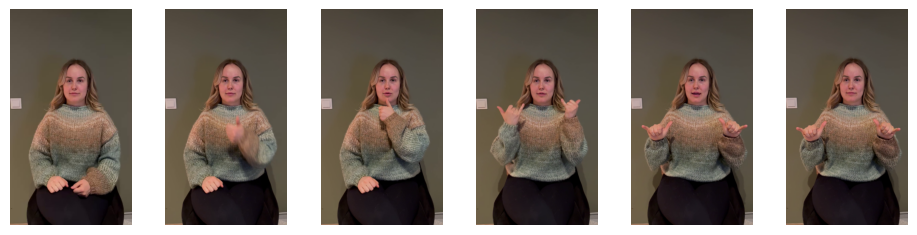

In [ ]:
video_folder = "nsl_test"
video_files = [f for f in os.listdir(video_folder) if f.lower().endswith('.mp4')]
selected_video = random.choice(video_files)

# Extract 6 evenly spaced frames from the video
def extract_frames(video_path, num_frames=6):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total - 1, num=num_frames, dtype=int)

    print(f"Video: {os.path.basename(video_path)}")
    print(f"Total frames: {total}")
    print(f"Selected indices: {indices}")

    frames = []
    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i in indices:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            frames.append((i, frame))  
        if len(frames) == num_frames:
            break
    cap.release()
    return frames

frames = extract_frames(os.path.join(video_folder, selected_video))

fig = plt.figure(figsize=(12, 2.8))
gs = gridspec.GridSpec(1, len(frames), wspace=0.01, hspace=0.01)

for i, (frame_idx, frame) in enumerate(frames):
    ax = fig.add_subplot(gs[i])
    ax.imshow(frame)
    #ax.set_title(f"Frame Index {frame_idx}", fontsize=9)
    ax.axis("off")

plt.show()

Video: IMG_0188.MP4
Total frames: 100
Selected indices: [ 0 19 39 59 79 99]


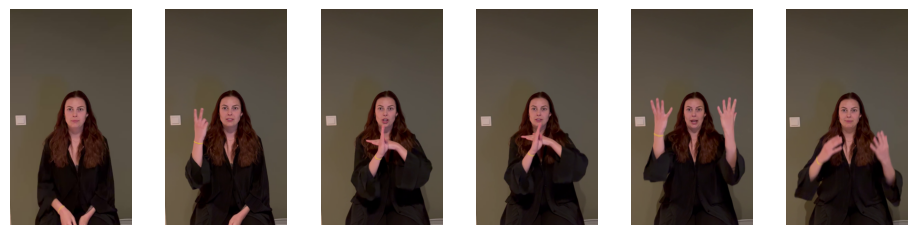

In [ ]:
video_folder = "nsl_test"
video_files = [f for f in os.listdir(video_folder) if f.lower().endswith('.mp4')]
selected_video = random.choice(video_files)

# Extract 6 evenly spaced frames from the video
def extract_frames(video_path, num_frames=6):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total - 1, num=num_frames, dtype=int)

    print(f"Video: {os.path.basename(video_path)}")
    print(f"Total frames: {total}")
    print(f"Selected indices: {indices}")

    frames = []
    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i in indices:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            frames.append((i, frame))  
        if len(frames) == num_frames:
            break
    cap.release()
    return frames

frames = extract_frames(os.path.join(video_folder, selected_video))

fig = plt.figure(figsize=(12, 2.8))
gs = gridspec.GridSpec(1, len(frames), wspace=0.01, hspace=0.01)

for i, (frame_idx, frame) in enumerate(frames):
    ax = fig.add_subplot(gs[i])
    ax.imshow(frame)
    #ax.set_title(f"Frame Index {frame_idx}", fontsize=9)
    ax.axis("off")

plt.show()